In [111]:
import os
import numpy as np
import pandas as pd

file_path = './test_hybrid_data_250912.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

In [49]:
df = df_raw.copy()
  

### pruning comparison 

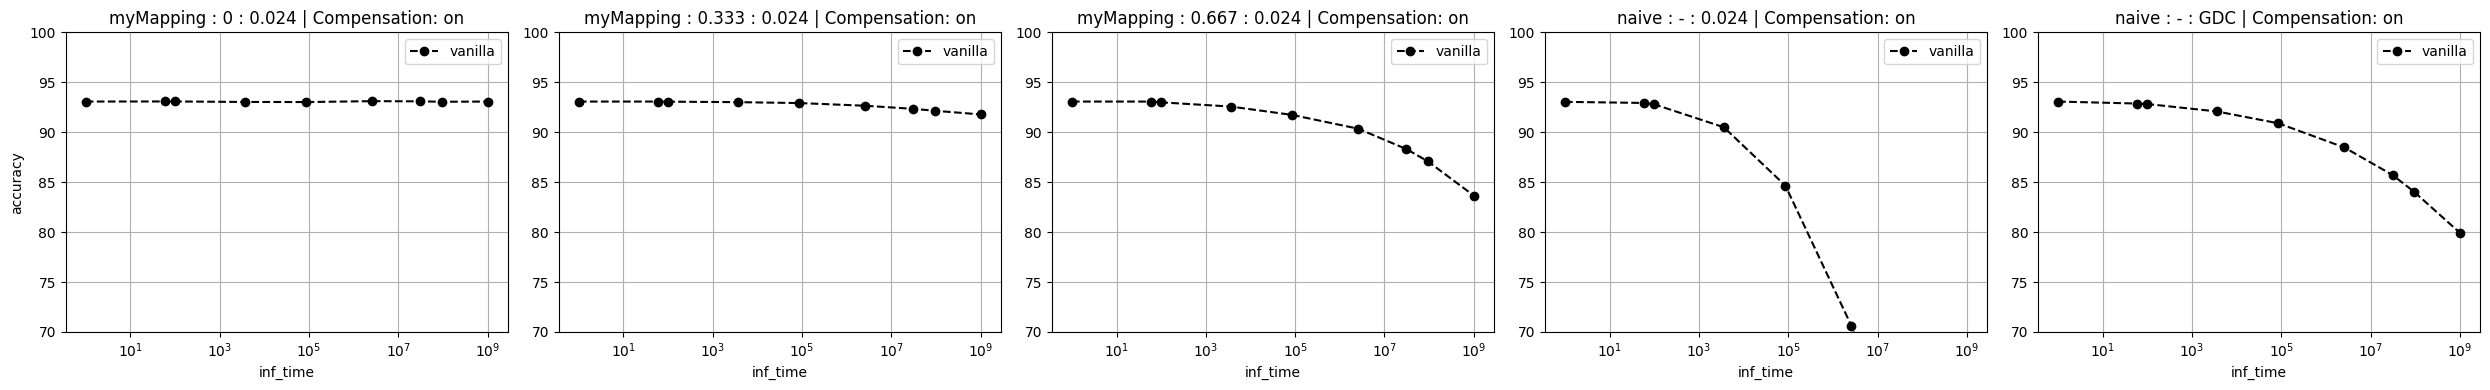

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# mapping_method 와 distortion_f 를 조합해서 새로운 column 생성
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str)+' : ' + df['alpha'].astype(str)

# 유일한 값
gdc_vals = sorted(df['GDC'].unique())
mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# subplot 구조 (row: GDC, column: mapping_distortion)
fig, axes = plt.subplots(len(gdc_vals), len(mapping_distortion_vals),
                         figsize=(5 * len(mapping_distortion_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, mapping_distortion in enumerate(mapping_distortion_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['mapping_distortion'] == mapping_distortion)]

        if subset.empty:
            ax.set_title(f'{mapping_distortion} | Compensation: {gdc}\n(No Data)')
            ax.axis('off')  # subplot 유지하지만 표시 안 함
            continue

        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model].sort_values('inf_time')
            if model == 'vanilla':
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, color='black', linestyle='--', marker='o')
            else:
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, marker='o', linestyle='-')

        ax.set_title(f'{mapping_distortion} | Compensation: {gdc}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        if gdc == "on":
            ax.set_ylim(70, 100)
        else:
            ax.set_ylim(0, 100)

        ax.legend()
        ax.grid(True)
        ax.set_xscale('log')

plt.tight_layout()
plt.show()

### mapping comparison

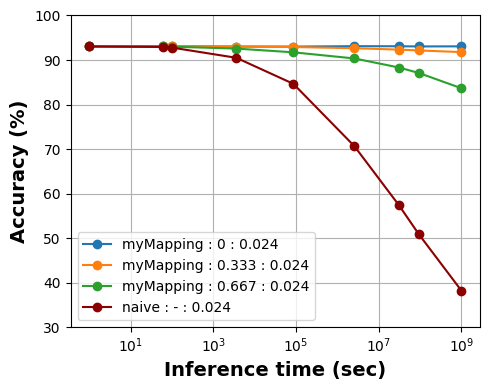

In [19]:

# 유일한 값 추출
gdc_vals = sorted(df['GDC'].unique())
model_vals = sorted(df['model_type'].unique())

df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str)+' : ' + df['alpha'].astype(str)

mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# subplot 개수 정의 (row: GDC, col: model_type)
fig, axes = plt.subplots(len(gdc_vals), len(model_vals),
                         figsize=(5 * len(model_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, model in enumerate(model_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['model_type'] == model)]

        for mapping_distortion in mapping_distortion_vals:
            md_data = subset[subset['mapping_distortion'] == mapping_distortion].sort_values('inf_time')

            # naive 중에서도 alpha == 'GDC' 조건 분리
            is_naive = 'naive' in mapping_distortion
            is_alpha_gdc = not md_data.empty and 'alpha' in md_data.columns and (md_data['alpha'] == 'GDC').any()

            if is_naive and is_alpha_gdc:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion + ' (avg. alpha)',
                        color='black', linestyle='--', marker='o')
            elif is_naive:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion,
                        color='darkred', linestyle='-', marker='o')
            else:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion, marker='o')
        
            # if 'naive' in mapping_distortion:
            #     ax.plot(md_data['inf_time'], md_data['accuracy'],
            #                 label=mapping_distortion, color='black', linestyle='--', marker='o')
            # else:
            #     ax.plot(md_data['inf_time'], md_data['accuracy'],
            #             label=mapping_distortion, marker='o')
            

        # ax.set_title(f' {model} | Compensation: {gdc}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('Inference time (sec)', fontsize=14, fontweight='semibold')
        if j == 0:
            ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='semibold')

        # GDC가 "on"일 때 ylim 설정
        if gdc == "on":
            ax.set_ylim(30, 100)


        ax.grid(True)
        ax.legend()
        ax.set_xscale('log')

plt.tight_layout()

### bar chart

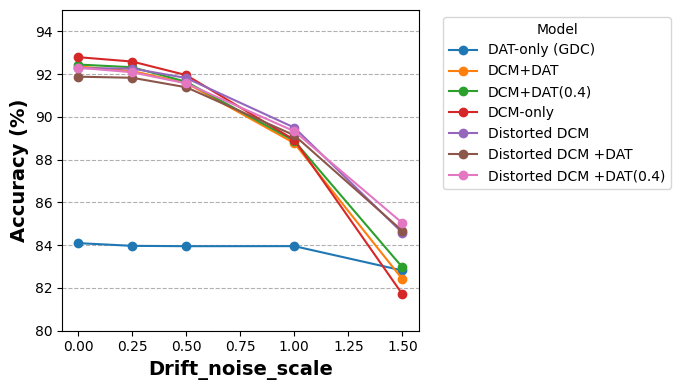

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_raw.copy()
df = df[df['read_noise_scale']==0]
df = df[df['model']!='IOtype']
df = df[df['IOparameter']=='non-ideal']

df = df[df['model']!='DAT-only']
# df = df[df['model']!='DCM+DAT']
# df = df[df['model']!='Distorted DCM +DAT']
# df = df[df['model']!='Distorted DCM']
df = df[df['model']!='vanilla+naïve']
df = df[df['model']!='vanilla+naïve (GDC)']

fig, ax = plt.subplots(figsize=(7,4))

for model, subdf in df.groupby("model"):
    subdf_sorted = subdf.sort_values("drift_noise_scale")
    ax.plot(
        subdf_sorted["drift_noise_scale"],
        subdf_sorted["accuracy"],
        marker="o",
        label=model
    )
    
# x축 및 기타 설정
ax.set_xlabel('Drift_noise_scale', fontsize=14, fontweight='semibold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='semibold')
# ax.set_title('Accuracy by drift_noise_scale and mapping_distortion')
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.legend()
ax.set_ylim(80,95)
# ax.set_xlim(0, 1.5)
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

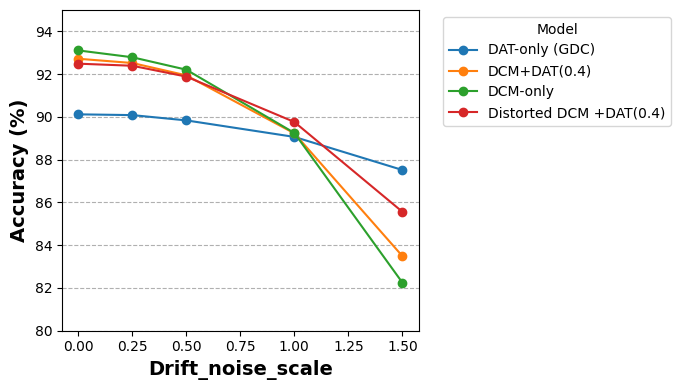

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_raw.copy()
df = df[df['read_noise_scale']==0]
df = df[df['IOparameter']=='ideal']
df = df[df['model']!='DAT-only']
df = df[df['model']!='DCM+DAT']
df = df[df['model']!='Distorted DCM']
df = df[df['model']!='Distorted DCM +DAT']
df = df[df['model']!='vanilla+naïve']
df = df[df['model']!='vanilla+naïve (GDC)']

fig, ax = plt.subplots(figsize=(7,4))

for model, subdf in df.groupby("model"):
    subdf_sorted = subdf.sort_values("drift_noise_scale")
    ax.plot(
        subdf_sorted["drift_noise_scale"],
        subdf_sorted["accuracy"],
        marker="o",
        label=model
    )
    
# x축 및 기타 설정
ax.set_xlabel('Drift_noise_scale', fontsize=14, fontweight='semibold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='semibold')
# ax.set_title('Accuracy by drift_noise_scale and mapping_distortion')
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(80,95)
# ax.set_xlim(0, 1.5)
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

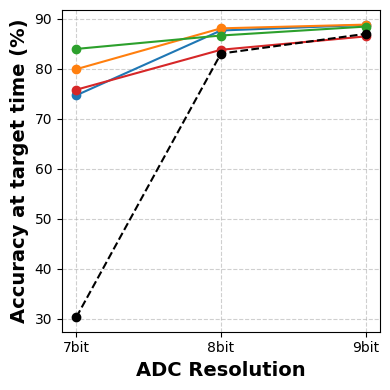

In [115]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_raw.copy()
df = df[df['model']=='IOtype']

fig, ax = plt.subplots(figsize=(4,4))

for model_type, subdf in df.groupby("model_type"):
    subdf_sorted = subdf.sort_values("adc_res")
    if model_type == 'vanilla':
        ax.plot(
            subdf_sorted["adc_res"],
            subdf_sorted["accuracy"],
            marker="o",
            label=model_type,
            color='black', linestyle='--'
        )
        continue

    else :
        ax.plot(
            subdf_sorted["adc_res"],
            subdf_sorted["accuracy"],
            marker="o",
            label=model_type
        )

ax.set_xlabel("ADC Resolution", fontsize=14, fontweight='semibold')
ax.set_ylabel("Accuracy at target time (%)", fontsize=14, fontweight='semibold')
ax.grid(True, linestyle="--", alpha=0.6)

# legend outside
# ax.legend(title="Model Type")

plt.tight_layout()
plt.show()